[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/35_lex_dec_ACTR_model_1.ipynb)

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import numpy as np
import pandas as pd

import pymc3 as pm

In [4]:
freq = np.array([242, 92.8, 57.7, 40.5, 30.6, 23.4, 19,
                 16, 13.4, 11.5, 10, 9, 7, 5, 3, 1])
rt = np.array([542, 555, 566, 562, 570, 569, 577, 587,
               592, 605, 603, 575, 620, 607, 622, 674])/1000
accuracy = np.array([97.22, 95.56, 95.56, 96.3, 96.11, 94.26,
                     95, 92.41, 91.67, 93.52, 91.85, 93.52,
                     91.48, 90.93, 84.44, 74.63])/100

## The simplest ACT-R model of lexical decision

Practiced memory retrieval is implemented in ACT-R, and it crucially relies on the power function model of declarative memory.

- the power function is used to compute (base) activation based on the number of practice trials / 'rehearsals' of a word
- the activation is then used to compute latency and accuracy for retrieval processes

For any word, the number of rehearsals that contribute to its base activation are crucially determined by its frequency. 

- there are other factors that determine the number and timing of the rehearsals, but we assume that the number of rehearsals is exclusively determined by frequency
- we will also assume, for simplicity, that presentations of a word are linearly spaced in time

Let's consider a 5-year old speaker. How can we estimate the time points at which a word was used in language interactions that the speaker participated in? 

- once we know these time points, we can compute the base activation for that word
- the activation, in turn, will make predictions about retrieval latency and retrieval accuracy that we can check against the Murray & Forster (2004) data in the table above

We know the lifetime of the speaker ($5$ years), so if we know the total number of words an average 5-year old speaker has been exposed to, we can easily calculate how many times a particular word was used on average, based on its frequency.

Once we find out how many times a word with a specific frequency was presented to our speaker during their lifetime, we can then present the word at linearly spaced intervals during the life span of the speaker (we use linearly spaced intervals for simplicity).

A good approximation of the number of words a speaker is exposed to per year can be found in **Hart, Betty, and Todd R Risley. 1995. Meaningful differences in the everyday experience of young American children. Baltimore: Paul H Brookes Publishing**:

- based on recordings of 42 families, Hart and Risley estimate that children comprehend between 10 million to 35 million words a year
    - depending to a large extent on the social class of the family
- this amount increases linearly with age.
- so a 5-year old has been exposed to anywhere between $50$ and $175$ million words total
- for simplicity, let's use the mean of $112.5$ million words as the total amount of words a 5-year old speaker has been exposed to
- this is a very conservative estimate because we ignore production, as well as the linguistic exposure associated with mass media
- the roughness of our estimate is not an issue for our purposes since we are interested in the _relative_ effect of frequency, not its _absolute_ effect:
    - we do not want to predict how much time the retrieval of a word from one frequency band requires, but how much time a word requires compared to a word from another frequency band

Below, we first compute the number of seconds in a year, and then the total number of seconds in the life span of the 5-year old speaker we're modeling.

- the function ```time_freq``` takes the mean frequency vector ```freq``` above and generates a schedule of linearly spaced word rehearsals / presentations for words from the 16 frequency bands studied by Murray and Forster
- the schedule of rehearsals covers the entire life span of our 5-year old speaker

In [14]:
SEC_IN_YEAR = 365*24*3600
SEC_IN_TIME = 15*SEC_IN_YEAR

def time_freq(freq):
    max_idx = np.int(np.max(freq) * 112.5)
    rehearsals = np.zeros((max_idx, len(freq)))
    for i in np.arange(len(freq)):
        temp = np.arange(np.int((freq[i]*112.5)))
        temp = temp * np.int(SEC_IN_TIME/(freq[i]*112.5))
        rehearsals[:len(temp),i] = temp
    return(rehearsals.T)

- we initialize our rehearsal schedule in the matrix ```rehearsals```
    - this matrix has as many rows as the number of rehearsals for the most frequent word band
     - ```np.max(freq)``` gives us the maximum frequency in words per million, which we multiply by $112.5$ million words
- the ```rehearsals``` matrix has 16 columns: as many columns as the frequency bands we are interested in.
- the ```for``` loop iterates over the 16 frequency bands and, for each frequency band `freq[i]`, it does the following:
    -  it identifies the total number of rehearsals for frequency band $i$ throughout the life span of the speaker (```freq[i]*112.5```)
    - it generates a vector with as many positions as there are rehearsals
    - at each position in that vector, we store the time of a rehearsal in seconds
    - the result is a vector ```temp``` of linearly spaced rehearsal times that we store in our full ```rehearsals``` matrix 
    - these rehearsal times can also be viewed as time periods since rehearsals if we reverse the vector
    - and it is time periods since rehearsals that we need to compute base activation; but we don't need to actually reverse the vector since we will have to sum the time periods to compute activation, and summation is commutative.
- finally, we return the full ```rehearsals``` matrix in transposed form because of the way we will use it to compute base activation (see below).

With this function in hand, we compute a rehearsal schedule for all 16 frequency bands - see below.

- we store the matrix in a ```theano``` variable called ```time```
- the ```theano``` library, which we import, enables us to do computations with multi-dimensional arrays efficiently, and provides the computational backbone for the Bayesian modeling library ```pymc3```
- we need to access it directly to be able to compute activations from the rehearsal schedule stored in the ```time``` matrix

In [38]:
import theano
import theano.tensor as tt

time = theano.shared(time_freq(freq), 'time')

Now that we have the rehearsal schedule, we can implement the lexical decision model:

In [39]:
lex_dec_model = pm.Model()

with lex_dec_model:
    # prior for base activation
    decay = pm.Uniform('decay', lower=0, upper=1)
    # priors for latency
    intercept = pm.Uniform('intercept', lower=0, upper=2)
    latency_factor = pm.Uniform('latency_factor', lower=0, upper=5)
    # priors for accuracy
    noise = pm.Uniform('noise', lower=0, upper=5)
    threshold = pm.Normal('threshold', mu=0, sd=10)

    # compute activation
    scaled_time = time ** (-decay)
    def compute_activation(scaled_time_vector):
        compare = tt.isinf(scaled_time_vector)
        subvector = scaled_time_vector[(1-compare).nonzero()]
        activation_from_time = tt.log(subvector.sum())
        return activation_from_time
    activation_from_time, _ = theano.scan(fn=compute_activation,\
                                          sequences=scaled_time)

    # latency likelihood
    mu_rt = pm.Deterministic('mu_rt', intercept +\
                          latency_factor*tt.exp(-activation_from_time))
    rt_observed = pm.Normal('rt_observed', mu=mu_rt, sd=0.01,\
                            observed=rt)

    # accuracy likelihood
    odds_reciprocal = tt.exp(-(activation_from_time - threshold)/noise)
    mu_prob = pm.Deterministic('mu_prob', 1/(1 + odds_reciprocal))
    prob_observed = pm.Normal('prob_observed', mu=mu_prob, sd=0.01,\
                              observed=accuracy)

In [40]:
with lex_dec_model:
    trace = pm.sample_smc(draws=20000, parallel=True) # try 5000 draws if too slow

Initializing SMC sampler...
Multiprocess sampling (12 chains in 12 jobs)
INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing loc

In [1]:
import arviz as az

In [42]:
az_trace = az.from_pymc3(trace, model=lex_dec_model)
az_trace

INFO (theano.gof.compilelock): Refreshing lock /home/ady/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.29-x86_64-3.8.5-64/lock_dir/lock


Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [43]:
az_trace.to_netcdf("lex_dec_model_ACTR_1.nc")

'lex_dec_model_ACTR_1.nc'

In [3]:
# to load the data from disk
# az_trace = az.from_netcdf("lex_dec_model_ACTR_1.nc")

- computing activations from the rehearsal schedule requires us to define a separate function ```compute_activation```
- this function assumes that the matrix ```scaled_time``` has been computed
    - to compute this matrix, we take our rehearsal schedule stored in the ```time``` matrix (time periods since rehearsals for all frequency bands) and raise these time periods to the ```-decay``` power
    - the result is a matrix that stores scaled times, i.e., the base activation boost contributed by each individual word rehearsal for all frequency bands

- some of the values in the ```time``` matrix were $0$; in the ```scaled_time``` matrix, they become infinity
- when we compute final activations, we want to discard all these infinity values , which is what the ```compute_activation``` function does:
    - it takes the 16 vectors of scaled times (for the 16 frequency bands) as inputs one at a time
    - then it identifies all the infinity values (line 14)
    - then it extracts the subvector of the input vector that contains only non-infinity values
    - with this subvector in hand, we can sum the scaled times and take the log of the result to obtain our final activation value, which the function returns to us

- with the function ```compute_activation``` in hand, we need to iterate over the 16 vectors of scaled times for our 16 frequency bands and compute the 16 resulting activations by applying the ```compute_activation``` function to each of these vectors of scaled times
    - however, ```theano``` is a purely functional language, which means it does not have ```for``` loops
    - we therefore use the ```theano.scan``` method to iteratively apply the ```compute_activation``` function to each of the 16 vectors in the ```scaled_time``` matrix
    
- the likelihoods of the lexical decision model are direct implementations of the retrieval latency and retrieval probability equations
    - we omit the latency exponent in the latency likelihood (`mu_rt`) because we assume it is set to its default value of $1$
    - we will see that this value is not appropriate, so we will have to move to a model in which the latency exponent is also fully modeled

- the dispersions around the mean RTs and mean probabilities are very minimal
    - we set the standard deviations to $0.01$
- the reason is that our observed values for both RTs and accuracy are not raw values, they are already means: the empirical means for the 16 frequency bands reported in Murray & Forster (2004)
- as such, we assume these means are very precise reflections of the underlying parameter values

- we could model these standard deviations explicitly, but we decided not to since we have only 32 observations here (16 for RTs, 16 for accuracies),and we are trying to estimate a fairly large number of parameters already: ```decay```, ```intercept```, ```latency_factor```, ```noise``` and ```threshold```

- the only new parameter in this model relative to the ACT-R probability and latency equations is the ```intercept``` parameter we use in the latency likelihood
- the intercept is supposed to absorb the time in the lexical decision task associated with operations other than memory retrieval: focusing visual attention, motor planning etc.

We then sample from the posterior distributions of the parameters and plot the results:

In [44]:
mu_rt = pd.DataFrame(trace['mu_rt'])
yerr_rt = [(mu_rt.mean()-mu_rt.quantile(0.025))*1000,\
           (mu_rt.quantile(0.975)-mu_rt.mean())*1000]

mu_prob = pd.DataFrame(trace['mu_prob'])
yerr_prob = [(mu_prob.mean()-mu_prob.quantile(0.025)),\
             (mu_prob.quantile(0.975)-mu_prob.mean())]

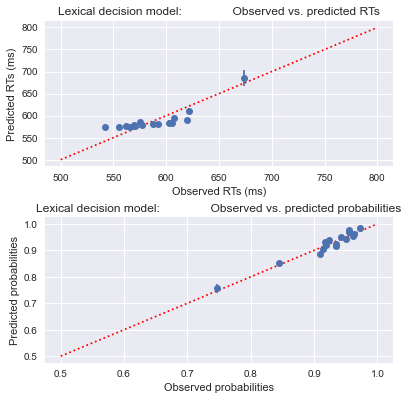

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(5.5, 5.5)

# plot 1: RTs
ax1.errorbar(rt*1000, mu_rt.mean()*1000, yerr=yerr_rt, marker='o',\
             linestyle='')
ax1.plot(np.linspace(500, 800, 10), np.linspace(500, 800, 10),\
         color='red', linestyle=':')
ax1.set_title('Lexical decision model:\
               Observed vs. predicted RTs')
ax1.set_xlabel('Observed RTs (ms)')
ax1.set_ylabel('Predicted RTs (ms)')
ax1.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 2: probabilities
ax2.errorbar(accuracy, mu_prob.mean(), yerr=yerr_prob, marker='o',\
             linestyle='')
ax2.plot(np.linspace(50, 100, 10)/100,\
                     np.linspace(50, 100, 10)/100,\
                     color='red', linestyle=':')
ax2.set_title('Lexical decision model:\
               Observed vs. predicted probabilities')
ax2.set_xlabel('Observed probabilities')
ax2.set_ylabel('Predicted probabilities')
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# clean up and save
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

An important thing to note about the ACT-R lexical decision model is that predictions about latencies and probabilities are theoretically connected:

- base activation is an essential ingredient in predicting both of them

In addition to connecting distinct kinds of observable behavior via the same unobservable theoretical construct(s), a hallmark of a good scientific theory is that it is falsifiable.

- the plots above show that an ACT-R model of lexical decision that set the latency exponent to its default value of $1$ (in effect omitting it) is empirically inadequate
- the bottom plot in the figure above shows that our lexical decision model does a good job of modeling retrieval probabilities: the predicted probabilities are very close to the observed ones, and they are precisely estimated (there are very few visible error bars protruding out of the plotted points)
- in contrast, latencies are poorly modeled, as the top plot in the figure above shows. The predicted RTs are not very close to the observed RTs and our model is very confident in its incorrect predictions (error bars are barely visible for most predicted RTs).